In [1]:
import os
import pandas as pd
import pathlib
import numpy as np

from itertools import combinations_with_replacement
from sklearn.model_selection import cross_val_score, train_test_split
from itertools import combinations_with_replacement
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import joblib

In [2]:
DATA_PATH = os.path.join(str(pathlib.Path().resolve().parents[1]), 'data', 'Wyscout')

In [3]:
leagues = ['England', 'France', 'Germany', 'Italy', 'Spain']
all_chains_df = pd.DataFrame() 

for league in leagues:
    chains_file_name = f'possession_chains_{league}.json'
    chains_path = os.path.join(DATA_PATH, 'possession_chain', chains_file_name)

    chains_df = pd.read_json(chains_path, encoding='unicode-escape')
    
    all_chains_df = pd.concat([all_chains_df, chains_df], ignore_index=True)
    
all_chains_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possession_chain,possession_chain_team,xG,shot_end,x0,y0,x1,y1,c0,c1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0.0,0,51.45,34.68,32.55,14.96,0.68,19.04
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0.0,0,32.55,14.96,53.55,17.00,19.04,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0.0,0,53.55,17.00,36.75,19.72,17.00,14.28
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0.0,0,36.75,19.72,43.05,3.40,14.28,30.60
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0.0,0,43.05,3.40,75.60,8.16,30.60,25.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085163,7,Acceleration,[{'id': 1801}],20623,"[{'y': 52, 'x': 45}, {'y': 25, 'x': 66}]",2565927,Others on the ball,682,2H,2932.188168,...,113505,682,0.0,0,47.25,32.64,69.30,51.00,1.36,17.00
2085164,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,...,113506,682,0.0,0,69.30,51.00,92.40,66.64,17.00,32.64
2085165,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,...,113506,682,0.0,0,92.40,66.64,101.85,53.72,32.64,19.72
2085166,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,...,113507,682,0.0,0,8.40,17.68,9.45,29.92,16.32,4.08


In [4]:
# model variables
var = ["x0", "x1", "c0", "c1"]

# combinations
inputs = []
# one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
# 2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
# 3 variable combinations 
inputs.extend(combinations_with_replacement(var, 3))

# make new columns
for i in inputs:
    # columns length 1 already exist 
    if len(i) > 1:
        # column name 
        column = ''
        x = 1
        for c in i:
            # add column name to be x0x1c0 for example
            column += c
            # multiply values in column
            x = x * all_chains_df[c]
        # create a new column in df
        all_chains_df[column] = x
        # add column to model variables
        var.append(column)
        
# investigate 3 columns
all_chains_df[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


In [20]:
def custom_logistic_obj(y_pred, y_true):
    # Calculate class weights
    class_weights = np.where(y_true == 1, ratio, 1)
    # Calculate gradients
    grad = (y_pred - y_true) * class_weights
    hess = class_weights
    return grad, hess

In [26]:
SEED = 123
xT_actions = all_chains_df.loc[(all_chains_df["eventName"] == "Pass") | (all_chains_df["subEventName"] == "Ground attacking duel")]

encoder = OneHotEncoder(sparse_output=False, drop='first')
cat_cols_encoded = encoder.fit_transform(xT_actions['subEventName'].values.reshape(-1, 1))

X = xT_actions[var].values  # do it with all competitions events?
X = np.hstack((X, cat_cols_encoded))

y = xT_actions["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(n_estimators=100, ccp_alpha=0, max_depth=4, min_samples_leaf=10, scale_pos_weight=ratio,
                       random_state=SEED)

# scores = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10, n_jobs=-1)
# print(np.mean(scores), np.std(scores))

C:\Users\Alvaro\anaconda3\envs\soccermatics\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))

y_pred = xgb.predict(X_test)
print(xgb.score(X_test, y_test))

[13:19:30] WARNING: D:\bld\xgboost-split_1666900898517\work\src\learner.cc:627: 
Parameters: { "ccp_alpha", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.7118977356643476
0.7094739120470577


In [33]:
xgb.predict_proba(X_test)[:, 1]

array([0.55115134, 0.23598027, 0.31309   , ..., 0.29469824, 0.2985997 ,
       0.6905706 ], dtype=float32)

In [31]:
auc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Score: {auc:.2f}")

AUC-ROC Score: 0.68


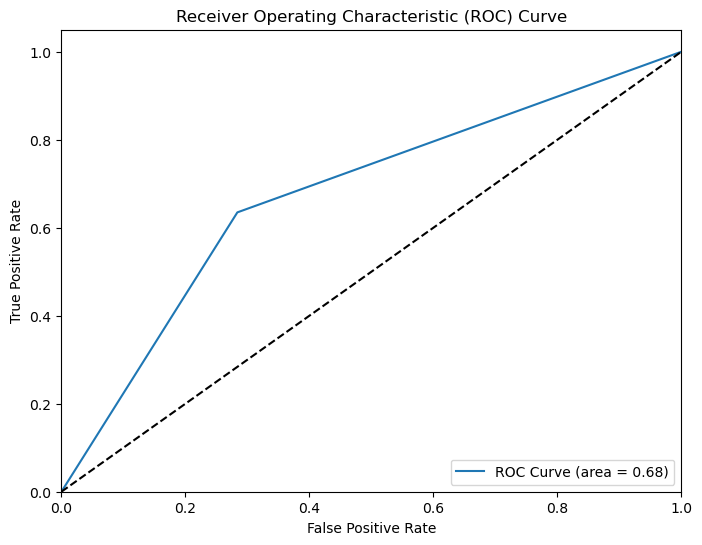

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
model_filename = 'xShot_cls_model.sav'
path_model = os.path.join(str(pathlib.Path().resolve().parents[1]), 'models', model_filename)
joblib.dump(xgb, path_model)

['C:\\Users\\Alvaro\\repos\\soccermatics\\models\\xShot_cls_model.sav']